In [44]:
import numpy as np
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import pandas as pd
import time

Descargamos datos que vienen previamente calculados:
- transacciones/interacciones de cada usuario
- transaciones para evaluar el modelo
- embeddings de descripciones calculados con BERT  
- embeddings de descripciones calculados con BERT-large
- datos de libros con información de titulo, descripcion, año de publicacion, entre otros.

In [2]:
!wget https://www.dropbox.com/s/57tel5zqopkssrh/books.csv?dl=0 -O books.csv
!wget https://www.dropbox.com/s/zpnnoy1i8ljf9fg/goodreads_bert_embeddings.npy?dl=0 -O goodreads_bert_embeddings.npy
!wget https://www.dropbox.com/s/a8hcc9w30y7r3jl/goodreads_bert_large_embeddings.npy?dl=0 -O goodreads_bert_large_embeddings.npy
!wget https://www.dropbox.com/s/dqeqpsr0vdvmcy0/goodreads_past_interactions.json?dl=0 -O goodreads_past_interactions.json
!wget https://www.dropbox.com/s/rjtzhmb2zbpp30q/goodreads_test_interactions.json?dl=0 -O goodreads_test_interactions.json

--2025-05-09 21:31:39--  https://www.dropbox.com/s/57tel5zqopkssrh/books.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5s6xrfnu17yi34sfhmskb/books.csv?rlkey=ymzokbyqw3qq2bq5okfao9w1z&dl=0 [following]
--2025-05-09 21:31:39--  https://www.dropbox.com/scl/fi/5s6xrfnu17yi34sfhmskb/books.csv?rlkey=ymzokbyqw3qq2bq5okfao9w1z&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbfde141e257af9c287d725e018.dl.dropboxusercontent.com/cd/0/inline/CpbBF2GQaLvW9HsuQSkPjoLgIzEhp1PrtvFrFS7xomXf9iRVwRHKLHzWfLK1JYoNyjbIshMObhJlLjKZfw_YhkMz_x9Gf1jcUJmraE9zgwGKZQmuES0hk4uA75-5RtZWJnHHsctJTbUFr8a1XJvI5wdM/file# [following]
--2025-05-09 21:31:39--  https://ucbfde141e257af9c287d725e018.dl.dropboxusercontent.com/cd/0/in

# Cargar datos adicionales

In [45]:
df_books = pd.read_csv('books.csv', sep=',')
df_books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,book_desc
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...,Winning will make you famous. Losing means cer...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...,About three things I was absolutely positive.F...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...,The unforgettable novel of a childhood in a sl...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...,Alternate Cover Edition ISBN: 0743273567 (ISBN...


In [4]:
df_books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url', 'book_desc'],
      dtype='object')

In [5]:
print("# ítems   --> ", df_books["book_id"].nunique())

# ítems   -->  4287


In [6]:
# diccionario con id del usuario y id de libros con los que ha interactuado en el pasado
with open('goodreads_past_interactions.json') as f:
    user_interactions = json.load(f)

# diccionario con id del usuario y id de libros para testear el modelo
with open('goodreads_test_interactions.json') as f:
    user_interactions_test = json.load(f)


In [7]:
# dict index 2 book id and vice-versa for recommendation
idx2bookid = {i: id_ for i, id_ in enumerate(df_books.book_id)}
bookid2idx = {id_:i for i, id_ in enumerate(df_books.book_id)}

In [8]:
print(len(user_interactions))

52821


### Distribución de Ratings

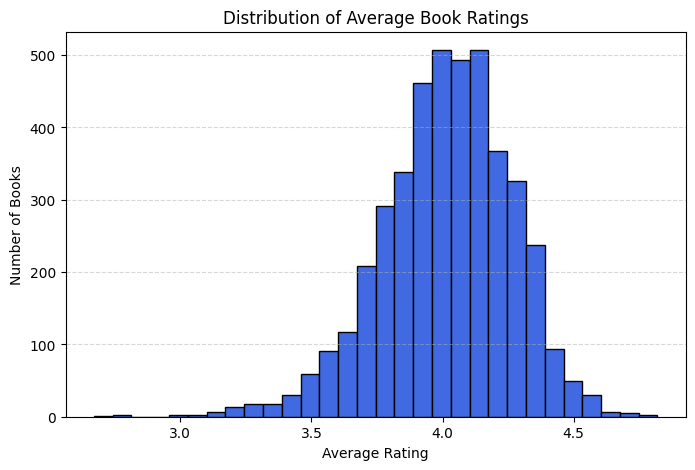

In [16]:
plt.figure(figsize=(8,5))
df_books['average_rating'].hist(bins=30, color='royalblue', edgecolor='black')
plt.title('Distribution of Average Book Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.grid(False)
# plt.xticks(range(0, 5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.savefig('average_rating_dist.png')
plt.show()

### Top 20 Most Rated Books

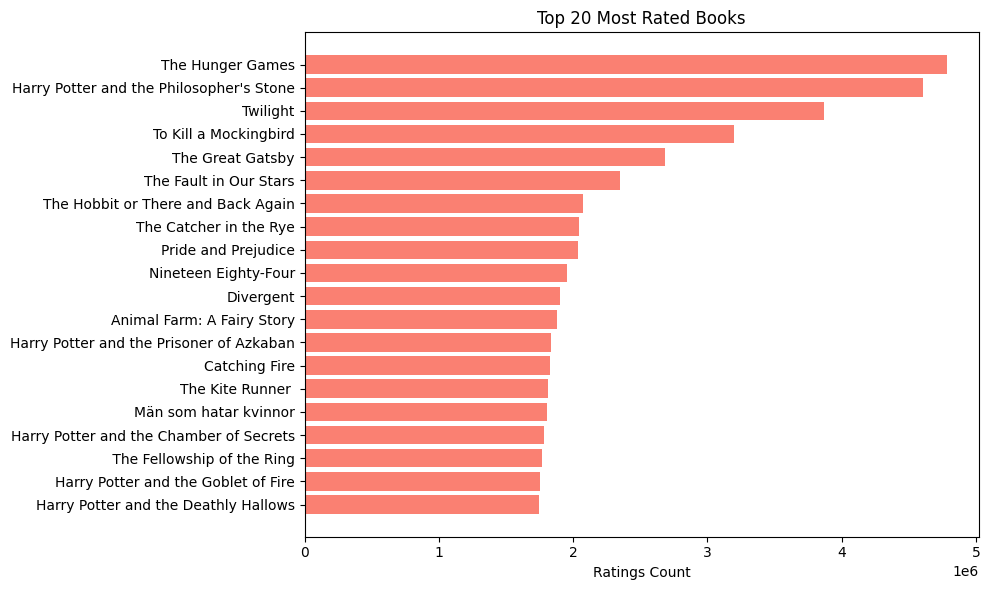

In [43]:
top_rated = df_books.sort_values(by='ratings_count', ascending=False).head(20)
plt.figure(figsize=(10,6))
plt.barh(top_rated['original_title'][::-1], top_rated['ratings_count'][::-1], color='salmon')
plt.xlabel('Ratings Count')
plt.title('Top 20 Most Rated Books')
plt.tight_layout()
plt.savefig('top_20_most_rated.png')
plt.show()

### Publication Year Distribution

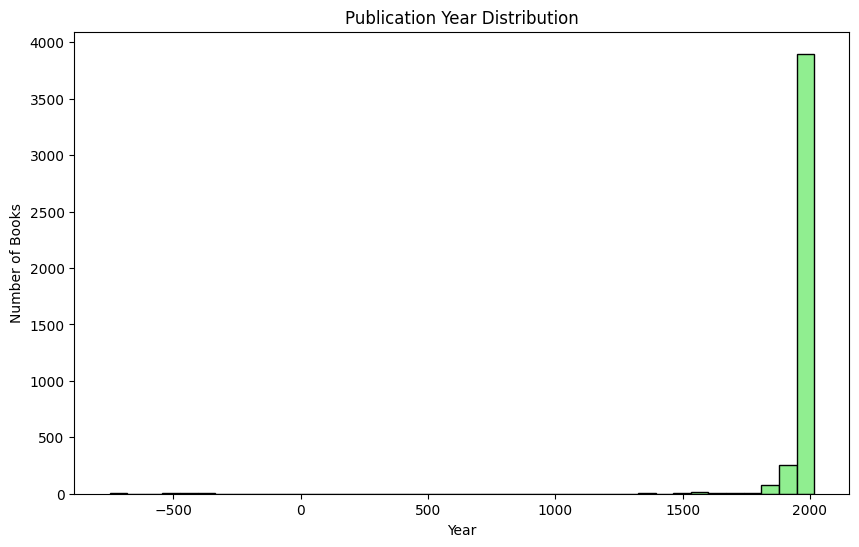

In [25]:
plt.figure(figsize=(10,6))
df_books['original_publication_year'].dropna().astype(int).hist(bins=40, color='lightgreen', edgecolor='black')
plt.title('Publication Year Distribution')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.grid(False)
plt.show()

### Most Frequent Authors

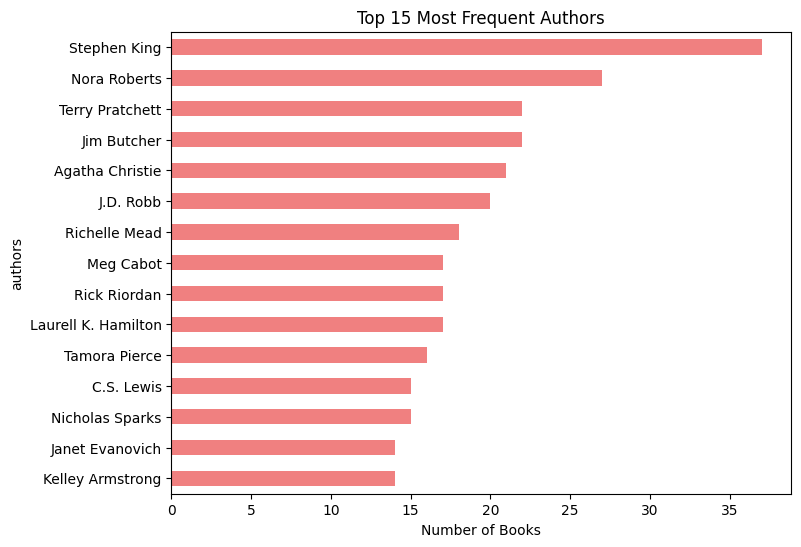

In [26]:
top_authors = df_books['authors'].value_counts().head(15)
top_authors.plot(kind='barh', figsize=(8,6), color='lightcoral')
plt.title('Top 15 Most Frequent Authors')
plt.xlabel('Number of Books')
plt.gca().invert_yaxis()
plt.show()

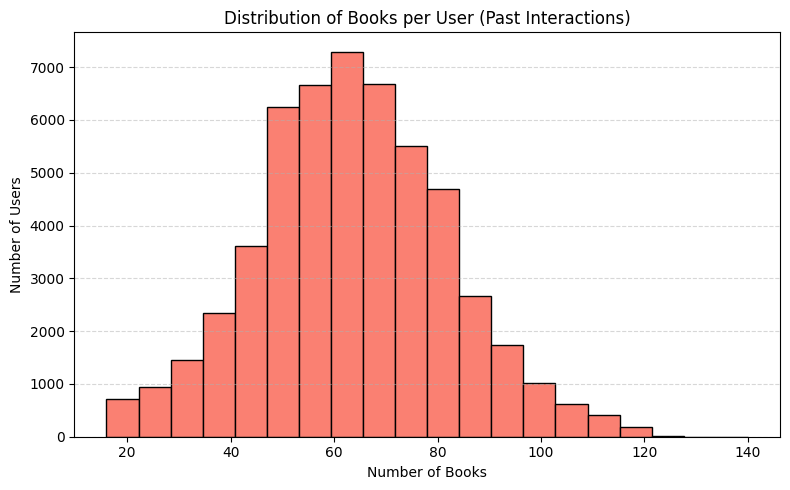

In [42]:
interaction_counts = [len(books) for books in user_interactions.values()]
plt.figure(figsize=(8,5))
plt.hist(interaction_counts, bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Books per User (Past Interactions)')
plt.xlabel('Number of Books')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('books_per_user_dist.png')
plt.show()

In [28]:
n_users = len(user_interactions)
n_items = df_books["book_id"].nunique()
n_interactions = sum(len(v) for v in user_interactions.values())
sparsity = 1 - (n_interactions / (n_users * n_items))

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of interactions: {n_interactions}")
print(f"Sparsity of interaction matrix: {sparsity:.4f}")


Number of users: 52821
Number of items: 4287
Number of interactions: 3354523
Sparsity of interaction matrix: 0.9852


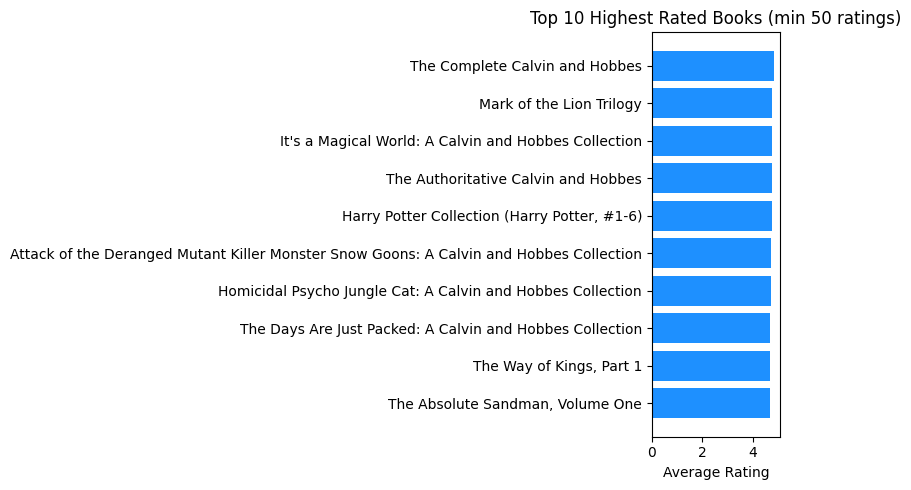

In [29]:
min_ratings = 50
popular_books = df_books[df_books['ratings_count'] > min_ratings]
top_avg_rated = popular_books.sort_values('average_rating', ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_avg_rated['original_title'][::-1], top_avg_rated['average_rating'][::-1], color='dodgerblue')
plt.xlabel('Average Rating')
plt.title(f'Top 10 Highest Rated Books (min {min_ratings} ratings)')
plt.tight_layout()
plt.show()


In [31]:
def compute_implicit_metrics(user_interactions, df_books):
    user_counts = [len(books) for books in user_interactions.values()]
    all_book_ids = set(b for books in user_interactions.values() for b in books)

    n_users = len(user_interactions)
    n_items = len(all_book_ids)
    total_interactions = sum(user_counts)
    avg_interactions_per_user = total_interactions / n_users if n_users else 0
    avg_interactions_per_item = total_interactions / n_items if n_items else 0
    max_interactions_by_user = max(user_counts) if user_counts else 0

    # Count interactions per item
    item_counts = {}
    for books in user_interactions.values():
        for b in books:
            item_counts[b] = item_counts.get(b, 0) + 1
    max_interactions_for_item = max(item_counts.values()) if item_counts else 0

    density = 100 * total_interactions / (n_users * df_books["book_id"].nunique()) if n_users else 0

    # Use book ratings from df_books
    relevant_books_df = df_books[df_books['book_id'].isin(all_book_ids)]
    avg_rating = relevant_books_df['average_rating'].mean()
    std_rating = relevant_books_df['average_rating'].std()

    return {
        "Number of Users": n_users,
        "Number of Items": n_items,
        "Total Interactions": total_interactions,
        "Avg Interactions/User": round(avg_interactions_per_user, 2),
        "Avg Interactions/Item": round(avg_interactions_per_item, 2),
        "Avg Book Rating (from df)": round(avg_rating, 2),
        "Rating Std Dev (from df)": round(std_rating, 2),
        "Max Interactions by a User": max_interactions_by_user,
        "Max Interactions for an Item": max_interactions_for_item,
        "Density (%)": round(density, 2),
    }

# Compute for training and validation sets
train_metrics = compute_implicit_metrics(user_interactions, df_books)
val_metrics = compute_implicit_metrics(user_interactions_test, df_books)

# Display in table
metrics_df = pd.DataFrame([train_metrics, val_metrics], index=["Training", "Validation"])
metrics_df.T


,Training,Validation
Number of Users,52821.00,100.00
Number of Items,4287.00,607.00
Total Interactions,3354523.00,1000.00
Avg Interactions/User,63.51,10.00
Avg Interactions/Item,782.49,1.65
Avg Book Rating (from df),4.01,4.03
Rating Std Dev (from df),0.25,0.24
Max Interactions by a User,140.00,10.00
Max Interactions for an Item,21899.00,8.00
Density (%),1.48,0.23
